### Con que datos nos quedamos?

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline


In [101]:
data = pd.read_csv('data/properati-AR-2017-08-01-properties-sell.csv')

In [102]:
data.columns

Index([u'id', u'created_on', u'operation', u'property_type', u'place_name',
       u'place_with_parent_names', u'country_name', u'state_name',
       u'geonames_id', u'lat-lon', u'lat', u'lon', u'price', u'currency',
       u'price_aprox_local_currency', u'price_aprox_usd',
       u'surface_total_in_m2', u'surface_covered_in_m2', u'price_usd_per_m2',
       u'price_per_m2', u'floor', u'rooms', u'expenses', u'properati_url',
       u'description', u'title', u'image_thumbnail'],
      dtype='object')

In [103]:
data.operation.value_counts() ## Son todos sell

sell    187482
Name: operation, dtype: int64

In [104]:
data.country_name.value_counts() ## son todos arg

Argentina    187482
Name: country_name, dtype: int64

In [105]:
data.drop(['id', 'operation','country_name', 'properati_url', 'image_thumbnail'], 1, inplace=True)
## el id no dice nada creo y las url tampoco

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187482 entries, 0 to 187481
Data columns (total 22 columns):
created_on                    187482 non-null object
property_type                 187482 non-null object
place_name                    187447 non-null object
place_with_parent_names       187482 non-null object
state_name                    187482 non-null object
geonames_id                   158318 non-null float64
lat-lon                       118761 non-null object
lat                           118761 non-null float64
lon                           118761 non-null float64
price                         154443 non-null float64
currency                      154441 non-null object
price_aprox_local_currency    154443 non-null float64
price_aprox_usd               154443 non-null float64
surface_total_in_m2           125027 non-null float64
surface_covered_in_m2         152420 non-null float64
price_usd_per_m2              105024 non-null float64
price_per_m2                  13

In [107]:
data.state_name.value_counts()

Capital Federal                 44152
Bs.As. G.B.A. Zona Norte        39888
Bs.As. G.B.A. Zona Oeste        22571
Buenos Aires Costa Atlántica    20694
Bs.As. G.B.A. Zona Sur          18135
Córdoba                         15777
Santa Fe                        13516
Buenos Aires Interior            4686
Río Negro                        1152
Neuquén                          1057
Mendoza                           927
Misiones                          817
Entre Ríos                        793
Tucumán                           715
Corrientes                        629
San Luis                          444
Salta                             372
Chubut                            329
La Pampa                          301
Catamarca                         126
Chaco                              95
San Juan                           86
Tierra Del Fuego                   69
Formosa                            66
Santa Cruz                         40
Jujuy                              32
La Rioja    

In [108]:
data = data[data['state_name'].str.contains('G.B.A') | data['state_name'].str.contains('Capital Federal')]
##El tp dice solo gba y caba

In [109]:
data.state_name.value_counts()

Capital Federal             44152
Bs.As. G.B.A. Zona Norte    39888
Bs.As. G.B.A. Zona Oeste    22571
Bs.As. G.B.A. Zona Sur      18135
Name: state_name, dtype: int64

In [110]:
##data['created_on'] = pd.to_datetime(data['created_on']) ## conversion de tipo
#data.loc[:,'place_name'] = data['place_name'].apply(lambda x: str(x)) # convierto los strings en utf-8 para soportar acentos y ñ

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124746 entries, 0 to 187480
Data columns (total 22 columns):
created_on                    124746 non-null object
property_type                 124746 non-null object
place_name                    124711 non-null object
place_with_parent_names       124746 non-null object
state_name                    124746 non-null object
geonames_id                   97866 non-null float64
lat-lon                       75504 non-null object
lat                           75504 non-null float64
lon                           75504 non-null float64
price                         110203 non-null float64
currency                      110202 non-null object
price_aprox_local_currency    110203 non-null float64
price_aprox_usd               110203 non-null float64
surface_total_in_m2           89385 non-null float64
surface_covered_in_m2         109180 non-null float64
price_usd_per_m2              79108 non-null float64
price_per_m2                  98873 no

In [112]:
data_wop = data[data['price'].isnull()]

In [113]:
data_wop.info()### Los datos sin precio no tienen ningun tipo de precio

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14543 entries, 28 to 187464
Data columns (total 22 columns):
created_on                    14543 non-null object
property_type                 14543 non-null object
place_name                    14542 non-null object
place_with_parent_names       14543 non-null object
state_name                    14543 non-null object
geonames_id                   12167 non-null float64
lat-lon                       9318 non-null object
lat                           9318 non-null float64
lon                           9318 non-null float64
price                         0 non-null float64
currency                      0 non-null object
price_aprox_local_currency    0 non-null float64
price_aprox_usd               0 non-null float64
surface_total_in_m2           10011 non-null float64
surface_covered_in_m2         10304 non-null float64
price_usd_per_m2              0 non-null float64
price_per_m2                  0 non-null float64
floor                 

In [114]:
data.dropna(axis=0,subset=['price'],inplace=True) ## drop de los datos sin precio

In [115]:
data.info()
## hay muchos datos con precio pero sin precios por m2 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110203 entries, 0 to 187480
Data columns (total 22 columns):
created_on                    110203 non-null object
property_type                 110203 non-null object
place_name                    110169 non-null object
place_with_parent_names       110203 non-null object
state_name                    110203 non-null object
geonames_id                   85699 non-null float64
lat-lon                       66186 non-null object
lat                           66186 non-null float64
lon                           66186 non-null float64
price                         110203 non-null float64
currency                      110202 non-null object
price_aprox_local_currency    110203 non-null float64
price_aprox_usd               110203 non-null float64
surface_total_in_m2           79374 non-null float64
surface_covered_in_m2         98876 non-null float64
price_usd_per_m2              79108 non-null float64
price_per_m2                  98873 non

In [116]:
data.describe() # HAY VALORES MAXIMOS RAROS EN surface_total_in_m2, surface_covered_in_m2
#price_per_m2, floor, rooms, expenses

,geonames_id,lat,lon,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses
count,8.569900e+04,66186.000000,66186.000000,1.102030e+05,1.102030e+05,1.102030e+05,79374.000000,98876.000000,7.910800e+04,9.887300e+04,10099.000000,43557.000000,1.414000e+04
mean,3.484056e+06,-34.593815,-58.507251,3.575550e+05,4.709830e+06,2.669291e+05,259.582307,148.406125,2.143136e+03,4.805880e+03,18.447470,2.940698,4.858812e+03
std,3.901128e+05,0.140147,0.186552,8.248369e+05,6.777257e+06,3.841002e+05,1620.742002,3226.358001,5.193960e+03,2.402496e+04,118.224471,1.483275,1.195227e+05
min,3.427208e+06,-38.416097,-68.869911,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,6.275958e-02,1.000000,1.000000,1.000000e+00
25%,3.429595e+06,-34.635786,-58.579658,1.050000e+05,1.759157e+06,9.970000e+04,53.000000,47.000000,1.122948e+03,1.521739e+03,2.000000,2.000000,1.000000e+03
50%,3.430782e+06,-34.599151,-58.474869,1.740000e+05,2.823120e+06,1.600000e+05,99.000000,79.000000,1.812500e+03,2.121212e+03,3.000000,3.000000,2.000000e+03
75%,3.435379e+06,-34.551807,-58.412199,3.400000e+05,5.293350e+06,3.000000e+05,240.000000,165.000000,2.521232e+03,3.000000e+03,6.000000,4.000000,4.000000e+03
max,6.693230e+06,-27.359704,-56.160010,1.000000e+08,8.212711e+08,4.654544e+07,200000.000000,987897.000000,1.271027e+06,4.000000e+06,2509.000000,32.000000,1.000150e+07


In [117]:
data[:].sort_values('floor',ascending=False).head(300) ## conclusion el dato del floor es basura

,created_on,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,...,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
129355,2017-07-16,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,3436077.0,"-34.574412,-58.473004",-34.574412,-58.473004,135000.0,...,135000.00,NaN,45.0,NaN,3000.000000,2509.0,1.0,NaN,Corredor Responsable: Gustavo Guastello - C.U....,Venta monoambiente en Belgrano R.Duplex.Cochera
126590,2017-07-12,house,Villa Rosa,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|Vill...,Bs.As. G.B.A. Zona Norte,3427377.0,"-34.411636,-58.843031",-34.411636,-58.843031,690000.0,...,690000.00,NaN,508.0,NaN,1358.267717,2177.0,5.0,NaN,Corredor Responsable: Uno Bienes Raices SRL - ...,VENTA CASA LA PRADERA PILAR
129364,2017-07-16,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,3436077.0,"-34.574659,-58.473337",-34.574659,-58.473337,390000.0,...,390000.00,NaN,133.0,NaN,2932.330827,2103.0,4.0,NaN,Corredor Responsable: Gustavo Guastello - C.U....,"Departamento de 4 amb c/Depcia, cochera y baulera"
98021,2017-05-10,apartment,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Tigre|,Bs.As. G.B.A. Zona Norte,NaN,"-34.433301,-58.586118",-34.433301,-58.586118,177800.0,...,177800.00,NaN,73.0,NaN,2435.616438,1609.0,4.0,NaN,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,NUEVO RIVERSIDE PRE-LANZAMIENTO
45588,2016-10-08,apartment,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Bs.As. G.B.A. Zona Norte,3427753.0,"-34.433301,-58.586118",-34.433301,-58.586118,48000.0,...,48000.00,NaN,73.0,NaN,657.534247,1609.0,4.0,NaN,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,NUEVO RIVERSIDE PRE-LANZAMIENTO
94644,2017-05-03,apartment,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Tigre|,Bs.As. G.B.A. Zona Norte,NaN,"-34.433301,-58.586118",-34.433301,-58.586118,171000.0,...,171000.00,NaN,73.0,NaN,2342.465753,1609.0,4.0,NaN,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,NUEVO RIVERSIDE PRE-LANZAMIENTO
77667,2017-03-14,apartment,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Tigre|,Bs.As. G.B.A. Zona Norte,NaN,"-34.433301,-58.586118",-34.433301,-58.586118,170960.0,...,170960.00,NaN,73.0,NaN,2341.917808,1609.0,4.0,NaN,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,NUEVO RIVERSIDE PRE-LANZAMIENTO
72100,2017-02-15,apartment,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Bs.As. G.B.A. Zona Norte,3427753.0,"-34.433301,-58.586118",-34.433301,-58.586118,170960.0,...,170960.00,NaN,73.0,NaN,2341.917808,1609.0,4.0,NaN,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,NUEVO RIVERSIDE PRE-LANZAMIENTO
47989,2016-10-28,apartment,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Tigre|,Bs.As. G.B.A. Zona Norte,NaN,"-34.433301,-58.586118",-34.433301,-58.586118,177800.0,...,177800.00,NaN,73.0,NaN,2435.616438,1609.0,4.0,NaN,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,NUEVO RIVERSIDE PRE-LANZAMIENTO
29122,2016-05-05,apartment,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Tigre|,Bs.As. G.B.A. Zona Norte,NaN,"-34.433301,-58.586118",-34.433301,-58.586118,148400.0,...,148400.00,NaN,73.0,NaN,2032.876712,1608.0,3.0,NaN,Corredor Responsable: Mauro Marvisi - CMCPSI 5...,NUEVO RIVERSIDE PRE-LANZAMIENTO


In [118]:
data[:].sort_values('rooms',ascending = False).head(50) ## Hay algunos que en la descripcion dicen
# que son hoteles en venta y estan guardados como apartment ¿? de ahi sale que tiene varias rooms
# Tambien hay ventas en conjunto, por ejemplo: Súper Oportunidad!!! 4 Dptos + 4 Locales


,created_on,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,...,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
121379,2017-07-04,apartment,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Bs.As. G.B.A. Zona Norte,3427753.0,"-34.4063431409,-58.6194849014",-34.406343,-58.619485,4260000.0,...,238916.46,96.0,96.0,2488.713125,44375.000000,NaN,32.0,NaN,FAS Departamento 3 ambientes en 1er piso con e...,FAS. Departamento 3 ambientes. Venta en pozo. ...
80821,2017-03-23,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|Mor...,Bs.As. G.B.A. Zona Oeste,3430550.0,NaN,NaN,NaN,70000.0,...,70000.00,NaN,51.0,NaN,1372.549020,NaN,25.0,NaN,Corredor Responsable: Hernan Perrone - CMCPDJM...,Departamento en Moreno Centro
66984,2017-02-05,apartment,Monserrat,|Argentina|Capital Federal|Monserrat|,Capital Federal,3430570.0,"-34.609988,-58.374932",-34.609988,-58.374932,300000.0,...,300000.00,NaN,472.0,NaN,635.593220,1.0,22.0,NaN,Corredor Responsable: Mario Gabriel Gerez - CU...,Venta Hotel Familiar Calle Peru al 100
112531,2017-06-13,apartment,Santa Barbara Barrio Cerrado,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Sant...,Bs.As. G.B.A. Zona Norte,NaN,"-34.425087,-58.5796585",-34.425087,-58.579658,170000.0,...,170000.00,55.0,55.0,3090.909091,3090.909091,NaN,22.0,NaN,Complejo Lagunas: incomparable y alucinante vi...,Hermosa planta baja en Venta en Santa Barbara
66983,2017-02-05,apartment,San Nicolás,|Argentina|Capital Federal|San Nicolás|,Capital Federal,6693229.0,"-34.605661,-58.388343",-34.605661,-58.388343,250000.0,...,250000.00,NaN,382.0,NaN,654.450262,1.0,17.0,NaN,Corredor Responsable: Mario Gabriel Gerez - CU...,Venta Hotel Familiar en 2 pisos
117141,2017-06-22,apartment,Recoleta,|Argentina|Capital Federal|Recoleta|,Capital Federal,3429595.0,"-34.587909,-58.383987",-34.587909,-58.383987,1700000.0,...,1700000.00,NaN,359.0,NaN,4735.376045,NaN,17.0,NaN,Corredor Responsable: Laura H. Zarate - CUCICB...,Piso de Categoría en Venta en Recoleta
177426,2017-07-22,apartment,Recoleta,|Argentina|Capital Federal|Recoleta|,Capital Federal,3429595.0,"-34.587909,-58.383987",-34.587909,-58.383987,1700000.0,...,1700000.00,NaN,359.0,NaN,4735.376045,NaN,17.0,NaN,Corredor Responsable: Mauro Marvisi - CUCICBA ...,Piso de Categoría en Venta en Recoleta
84470,2017-04-05,house,Nordelta,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nord...,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,2500000.0,...,2500000.00,NaN,20.0,NaN,125000.000000,NaN,16.0,NaN,Corredor Responsable: Matias Castelli - CUCICB...,VENTA CASA BARRIO CERRADO LOS CASTORES
120913,2017-07-04,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Capital Federal,3430234.0,"-34.5724752,-58.4284225",-34.572475,-58.428422,1200000.0,...,1200000.00,590.0,590.0,2033.898305,2033.898305,NaN,15.0,NaN,Oportunidad 600 frente al Polo con 5 cocheras:...,Clay 3100
52026,2016-11-18,apartment,Congreso,|Argentina|Capital Federal|Congreso|,Capital Federal,3435259.0,"-34.611902,-58.388719",-34.611902,-58.388719,450000.0,...,450000.00,NaN,620.0,NaN,725.806452,NaN,14.0,NaN,Corredor Responsable: Marcelo Trujillo - CUCIC...,VENTA 2PH LOTE PROPIO 3PLANTAS+SUB. Congreso


In [119]:
data[:].sort_values('expenses',ascending = False) # Hay expensas que solo las pagaria Ricardo Fort y valores NaN

,created_on,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,...,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
115722,2017-06-20,apartment,Villa Luro,|Argentina|Capital Federal|Villa Luro|,Capital Federal,3427407.0,"-34.6395149,-58.5071076",-34.639515,-58.507108,140000.0,...,140000.00,46.0,43.0,3043.478261,3255.813953,NaN,2.0,10001500.0,Venta de Departamento 2 AMBIENTES en Villa Lur...,DEPARTAMENTO EN VENTA
115723,2017-06-20,apartment,Villa Luro,|Argentina|Capital Federal|Villa Luro|,Capital Federal,3427407.0,"-34.6395149,-58.5071076",-34.639515,-58.507108,160000.0,...,160000.00,49.0,43.0,3265.306122,3720.930233,NaN,2.0,10001500.0,Venta de Departamento 2 AMBIENTES en Villa Lur...,DEPARTAMENTO EN VENTA
53107,2016-11-23,apartment,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,3436077.0,NaN,NaN,NaN,750000.0,...,750000.00,198.0,173.0,3787.878788,4335.260116,NaN,5.0,865906.0,DEPARTAMENTO EN VENTA | BELGRANO - Capital ...,DEPARTAMENTO EN VENTA
105410,2017-05-30,apartment,Merlo,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|,Bs.As. G.B.A. Zona Oeste,3430696.0,"-34.6966566667,-58.7618113508",-34.696657,-58.761811,550000.0,...,30846.02,NaN,NaN,NaN,NaN,NaN,NaN,550000.0,CODIGO: 2704-305 Bach ubicado en: Bach - Publ...,"Departamento planta alta, $550,000 y cuotas, f..."
24034,2016-02-12,house,Monte Grande,|Argentina|Bs.As. G.B.A. Zona Sur|Esteban Eche...,Bs.As. G.B.A. Zona Sur,NaN,"-34.8052239459,-58.4678842863",-34.805224,-58.467884,500000.0,...,500000.00,NaN,NaN,NaN,NaN,NaN,NaN,500000.0,CODIGO: 2716-PDC 294 ubicado en: JUAN BAUTISTA...,EXCELENTE CHALET DE CATEGORIA - LOTE DE 2000 M...
2550,2014-03-25,apartment,San Miguel,|Argentina|Bs.As. G.B.A. Zona Norte|San Miguel|,Bs.As. G.B.A. Zona Norte,NaN,"-34.5405788217,-58.7178335571",-34.540579,-58.717834,80000.0,...,80000.00,NaN,NaN,NaN,NaN,NaN,NaN,440000.0,CODIGO: 34-049 ubicado en: Alem - Publicado p...,"Departamento en Venta en San Miguel, Buenos Aires"
41535,2016-09-03,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,Bs.As. G.B.A. Zona Oeste,3430550.0,"-34.6366765,-58.7827367",-34.636677,-58.782737,250000.0,...,250000.00,1100.0,370.0,227.272727,675.675676,NaN,NaN,250000.0,CODIGO: 1581-Lopee de Vega ubicado en: LOPE DE...,OPORTUNIDAD VENDO O PERMUTO EN MORENO EXCELENT...
20124,2015-10-20,house,Ituzaingó,|Argentina|Bs.As. G.B.A. Zona Oeste|Ituzaingó|,Bs.As. G.B.A. Zona Oeste,3433359.0,"-34.6570243,-58.6753978",-34.657024,-58.675398,230000.0,...,230000.00,NaN,NaN,NaN,NaN,NaN,NaN,220000.0,CODIGO: 531-238 ubicado en: xxx - Publicado p...,Ituzaingo C/Est. y 5 C/Av.Rivadavia Chalet S/3...
101908,2017-05-19,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,Bs.As. G.B.A. Zona Oeste,3430550.0,"-34.6217387,-58.7384513",-34.621739,-58.738451,290000.0,...,16264.26,450.0,NaN,36.142800,NaN,NaN,NaN,220000.0,CODIGO: 1581-lote 2 de abril ubicado en: 2 DE ...,VENDO LOTE EN MORENO SOBRE CALLE 2 DE ABRIL A ...
35358,2016-07-14,apartment,Olivos,|Argentina|Bs.As. G.B.A. Zona Norte|Vicente Ló...,Bs.As. G.B.A. Zona Norte,3430310.0,"-34.5116171,-58.4995662",-34.511617,-58.499566,217000.0,...,217000.00,118.0,95.0,1838.983051,2284.210526,NaN,NaN,217000.0,CODIGO: 1974-504 ubicado en: Pelliza 2300 - P...,"Chalet de 3 Ambientes , cochera , terraza, pat..."


In [120]:
data[:].sort_values('surface_total_in_m2',ascending = False) #El title corrobora el valor de surface

,created_on,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,...,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,title
61220,2017-01-07,apartment,Bs.As. G.B.A. Zona Oeste,|Argentina|Bs.As. G.B.A. Zona Oeste|,Bs.As. G.B.A. Zona Oeste,3435907.0,NaN,NaN,NaN,16000.0,...,16000.0,200000.0,NaN,0.080000,NaN,NaN,NaN,NaN,"FracciÃ³n de 20 hA, en venta, al lado de Santa...",DEPARTAMENTO EN VENTA
90655,2017-04-27,apartment,San Telmo,|Argentina|Capital Federal|San Telmo|,Capital Federal,3428113.0,"-34.6213421,-58.3741846",-34.621342,-58.374185,46545445.0,...,46545445.0,200000.0,NaN,232.727225,NaN,NaN,3.0,NaN,dsdffhghvcvbcdfdfghdfhghkjhkhjklhjkfgvghfghnfg...,Departamento venta
58232,2016-12-20,house,Islas,|Argentina|Bs.As. G.B.A. Zona Norte|San Fernan...,Bs.As. G.B.A. Zona Norte,3853654.0,"-34.05462,-58.60402",-34.054620,-58.604020,150000.0,...,150000.0,110000.0,209.0,1.363636,717.703349,NaN,5.0,NaN,VENTA DE CASA EN EL DELTA SOBRE RIO PARANA MIN...,CASA EN VENTA
51626,2016-11-18,house,Capital Federal,|Argentina|Capital Federal|,Capital Federal,3433955.0,NaN,NaN,NaN,1150000.0,...,1150000.0,105010.0,363.0,10.951338,3168.044077,NaN,NaN,NaN,"PB: hall acceso, living, comedor, cocina, lava...","Casa 105010m² con 2 Plantas, Argentina, Capita..."
12071,2015-05-12,house,Capital Federal,|Argentina|Capital Federal|,Capital Federal,3433955.0,NaN,NaN,NaN,1150000.0,...,1150000.0,100000.0,600.0,11.500000,1916.666667,NaN,NaN,NaN,IMPORTANTE CASA QUINTARODEADA DE MURO CON SEGU...,"Casa 100000m² con Cochera, Argentina, Capital ..."
22447,2015-12-25,house,Islas,|Argentina|Bs.As. G.B.A. Zona Norte|San Fernan...,Bs.As. G.B.A. Zona Norte,3853654.0,"-34.4430618,-58.5579643",-34.443062,-58.557964,200000.0,...,200000.0,100000.0,170.0,2.000000,1176.470588,NaN,4.0,NaN,"HERMOSA PROPIEDAD SOBRE RIO CARABELAS, SON 10 ...",RIO CARABELAS: 2 SECCION DE ISLAS 10 Ha. CON E...
42474,2016-09-13,house,Maschwitz,|Argentina|Bs.As. G.B.A. Zona Norte|Escobar|Ma...,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,1275000.0,...,1275000.0,94612.0,NaN,13.476092,NaN,NaN,NaN,NaN,"FRACCIÃN DE TERRENO DE APROX 9,5Ha. PARA UN DE...","Casa 94612m², Escobar, Maschwitz, por U$S 1.27..."
172483,2017-07-19,store,Lomas de Zamora,|Argentina|Bs.As. G.B.A. Zona Sur|Lomas de Zam...,Bs.As. G.B.A. Zona Sur,3431270.0,"-34.7819166,-58.4250454",-34.781917,-58.425045,6000000.0,...,6000000.0,93000.0,30000.0,64.516129,200.000000,NaN,NaN,NaN,CODIGO: 2484-FB0007 ubicado en: Garibaldi al 2...,LAVALLOL. Predio Industrial de 93.000 m2 y 30....
3807,2014-03-25,house,El Palomar,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|El P...,Bs.As. G.B.A. Zona Oeste,3434509.0,NaN,NaN,NaN,90000.0,...,90000.0,90000.0,440.0,1.000000,204.545455,NaN,NaN,NaN,CODIGO: 401-2424 ubicado en: Pampa 1456 - Pub...,"Casa en Venta en El Palomar, Morón, Buenos Aires"
16008,2015-07-30,house,Haedo,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Haedo|,Bs.As. G.B.A. Zona Oeste,NaN,NaN,NaN,NaN,400000.0,...,400000.0,67548.0,150.0,5.921715,2666.666667,NaN,5.0,NaN,Chalet en gran lote de 15.60 x 43.30 fos 0.6 ...,Chalet en Venta Haedo / Moron (A130 614)


# Voy a agrupar por años

In [121]:
data['created_on'].sort_values(ascending = False)[:] # los años van de 2017 a 2012

187480    2017-08-01
187188    2017-08-01
187202    2017-08-01
187201    2017-08-01
187200    2017-08-01
187199    2017-08-01
187197    2017-08-01
187196    2017-08-01
187195    2017-08-01
187191    2017-08-01
187187    2017-08-01
187205    2017-08-01
187185    2017-08-01
187184    2017-08-01
187182    2017-08-01
187181    2017-08-01
187180    2017-08-01
187178    2017-08-01
187174    2017-08-01
187173    2017-08-01
187204    2017-08-01
187207    2017-08-01
187171    2017-08-01
187227    2017-08-01
187241    2017-08-01
187239    2017-08-01
187238    2017-08-01
187237    2017-08-01
187235    2017-08-01
187232    2017-08-01
             ...    
55        2013-05-15
58        2013-05-15
59        2013-05-15
60        2013-05-15
61        2013-05-15
62        2013-05-15
63        2013-05-15
64        2013-05-15
57        2013-05-15
44        2013-05-10
43        2013-05-10
42        2013-05-05
39        2013-04-17
38        2013-04-12
37        2013-04-05
34        2013-03-28
36        201

In [122]:
sells_2017 = data[data['created_on'].str.contains("2017")]
sells_2016 = data[data['created_on'].str.contains("2016")]
sells_2015 = data[data['created_on'].str.contains("2015")]
sells_2014 = data[data['created_on'].str.contains("2014")]
sells_2013 = data[data['created_on'].str.contains("2013")]
sells_2012 = data[data['created_on'].str.contains("2012")]

In [123]:
serie_cant_ventas = pd.Series([sells_2017['created_on'].count(),sells_2016['created_on'].count(),
                              sells_2015['created_on'].count(),sells_2014['created_on'].count(),
                              sells_2013['created_on'].count(),sells_2012['created_on'].count()],index=['2017','2016','2015','2014','2013','2012'])

data.insert(1,'Day',pd.Series([]),)
data.insert(1,'Month',pd.Series([]),)
data.insert(1,'Year',pd.Series([]),)
contador = 0
for date in data['created_on']:
    data['Year'][contador] = str(date[0:4])
    data['Month'][contador] = str(date[5:7])
    data['Day'][contador] = str(date[8:])
    contador += 1
    
# aca es imposible de hacer esto son muchos datos... En spark capaz se puede

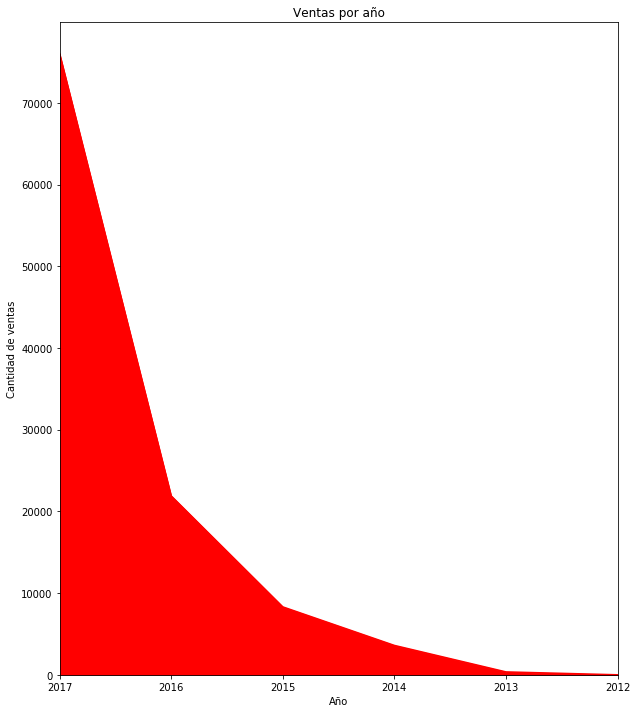

In [124]:
fig = plt.figure(figsize=(10,12));
plt.title(u"Ventas por año")
plt.ylabel("Cantidad de ventas")
plt.xlabel(u"Año")
serie_cant_ventas.sort_values(ascending=False)[:].plot(kind='area',color='red')

# Voy a agrupar por barrios en capital federal

In [248]:
serie_nombre_barrios_cap_federal_oficiales = pd.Series(['Agronomía',u'Almagro',u'Balvanera',u'Barracas',u'Belgrano',
                                                          u'Boedo',u'Caballito',u'Chacarita',u'Coghlan',u'Colegiales',
                                                          'Constitución',u'Flores',u'Floresta',u'Boca',u'Paternal',
                                                          u'Liniers',u'Mataderos',u'Monte Castro',u'Monserrat',
                                                          u'Pompeya','Nuñez',u'Palermo',u'Parque Avellaneda',
                                                          u'Parque Chacabuco',u'Parque Chas',u'Parque Patricios',
                                                          u'Puerto Madero',u'Recoleta',u'Retiro',u'Saavedra',
                                                          u'San Cristobal','San Nicolás',u'San Telmo',u'Versalles',
                                                          u'Villa Crespo',u'Villa Devoto',u'Villa General Mitre',
                                                          u'Villa Lugano',u'Villa Luro',u'Villa Ortuzar',
                                                          'Villa Pueyrredón',u'Villa Real',u'Villa Riachuelo',
                                                          u'Villa Santa Rita',u'Villa Soldati',u'Villa Urquiza',
                                                          u'Villa del Parque',u'Velez Sarsfield'])

serie_nombre_barrios_cap_federal_NO_oficiales = pd.Series([u'Abasto',u'Alto Palermo',u'Bajo Belgrano'])

barrios_oficiales = data[data['place_name'].isin(serie_nombre_barrios_cap_federal_oficiales)]
barrios_no_oficiales = data[ (data['place_name'].isin(serie_nombre_barrios_cap_federal_oficiales) == False) & 
                    (data['state_name'].str.contains('Capital Federal')) & 
                    (data['place_name'].str.contains("Capital Federal") == False) ]
barrios_que_solo_dicen_capital_federal  = data[(data['place_name'].isin(serie_nombre_barrios_cap_federal_oficiales) == False) & (
                                        data['place_name'].str.contains("Capital Federal"))]

# Corroboro que la cantidad de las 3 variables sea igual a la cantidad de registros que hay en capital federal

In [258]:
registros_en_cap_federal = data[data['state_name'].str.contains('Capital Federal')]

a = barrios_oficiales['place_name'].count() + barrios_no_oficiales['place_name'].count() + barrios_que_solo_dicen_capital_federal['place_name'].count()
b = registros_en_cap_federal['place_name'].count()
print( a)
print(b)

39480
39480


In [249]:
barrios_no_oficiales.groupby('place_name').size() # Hay que ver que hacemos con estos barrios si los agrupamos a donde
#le corresponde por barrio oficial o los usamos asi nomas

place_name
Abasto                   132
Barrio Norte            1318
Catalinas                  3
Centro / Microcentro     348
Congreso                 438
Las Cañitas              204
Once                     292
Palermo Chico            270
Palermo Hollywood        616
Palermo Soho             439
Palermo Viejo             64
Parque Centenario         95
Tribunales               114
dtype: int64

In [254]:
barrios_que_solo_dicen_capital_federal.groupby('place_name').size() # Habra que ver como sacar informacion de la descripcion y titulo para ubicar
#los que no tienen lat y long

place_name
Capital Federal    1800
dtype: int64

In [255]:
group_por_barrios_oficiales = barrios_oficiales.groupby('place_name').size().sort_values(ascending = False)
group_por_barrios_oficiales.sum()

33347

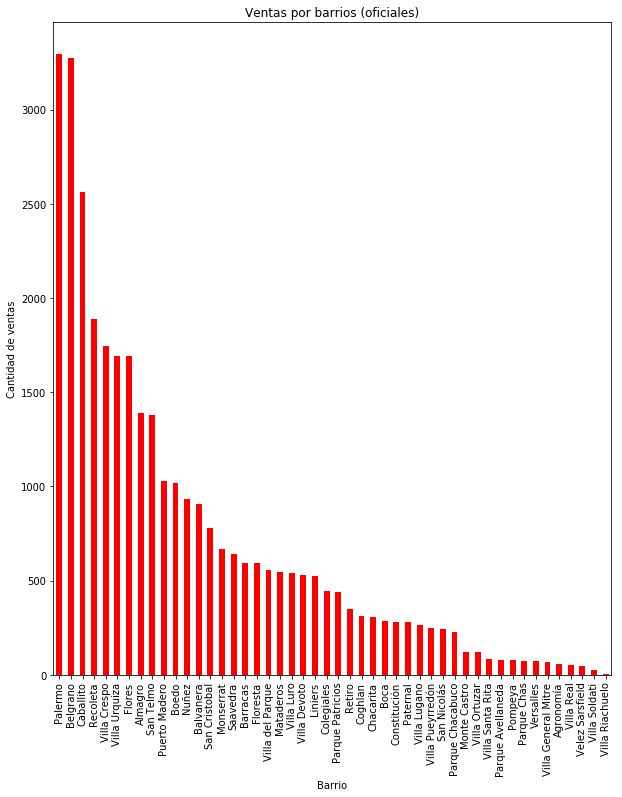

In [257]:
fig = plt.figure(figsize=(10,12));
plt.title(u"Ventas por barrios (oficiales)")
plt.ylabel("Cantidad de ventas")
group_por_barrios_oficiales.sort_values(ascending=False)[:].plot(kind='bar',color='red')
plt.xlabel("Barrio")